# PPO: The Algorithm Behind RLHF

**Goal**: Deeply understand PPO — the most important algorithm for LLM alignment.

## Why PPO Matters

PPO is used in:
- **InstructGPT / ChatGPT**: Fine-tuning GPT with human preferences
- **Claude**: Anthropic's alignment training
- **Game AI**: OpenAI Five (Dota 2), robotic control

It's the default RL algorithm for RLHF because it's **stable, simple, and works well**.

## PPO in One Sentence

> Update the policy to maximize reward, but **don't change it too much** in one step.

In [1]:
import torch
import numpy as np
import gymnasium as gym
import matplotlib.pyplot as plt

from rl_lab.agents.ppo import PPOAgent, ActorCritic
from rl_lab.utils.common import get_device

device = get_device()
print(f"Using device: {device}")

Using device: mps


---
## 1. The Evolution: REINFORCE → A2C → TRPO → PPO

### REINFORCE
$$\nabla J = \mathbb{E}[\nabla \log \pi(a|s) \cdot G_t]$$
Problem: High variance, unstable

### A2C (Advantage Actor-Critic)
$$\nabla J = \mathbb{E}[\nabla \log \pi(a|s) \cdot A(s,a)]$$
Better: Use advantage, TD updates. But gradient steps can be too large.

### TRPO (Trust Region Policy Optimization)
Constrain KL divergence: $D_{KL}(\pi_{old} || \pi_{new}) \leq \delta$
Works but complex (conjugate gradient, line search).

### PPO: TRPO Made Simple
Instead of a hard KL constraint, **clip the objective**:

$$L^{CLIP} = \mathbb{E}\left[\min\left(r(\theta) A, \text{clip}(r(\theta), 1-\varepsilon, 1+\varepsilon) A\right)\right]$$

Where $r(\theta) = \frac{\pi_{new}(a|s)}{\pi_{old}(a|s)}$ is the probability ratio.

---
## 2. Understanding the Clipped Objective

The clip prevents the policy from changing too much.

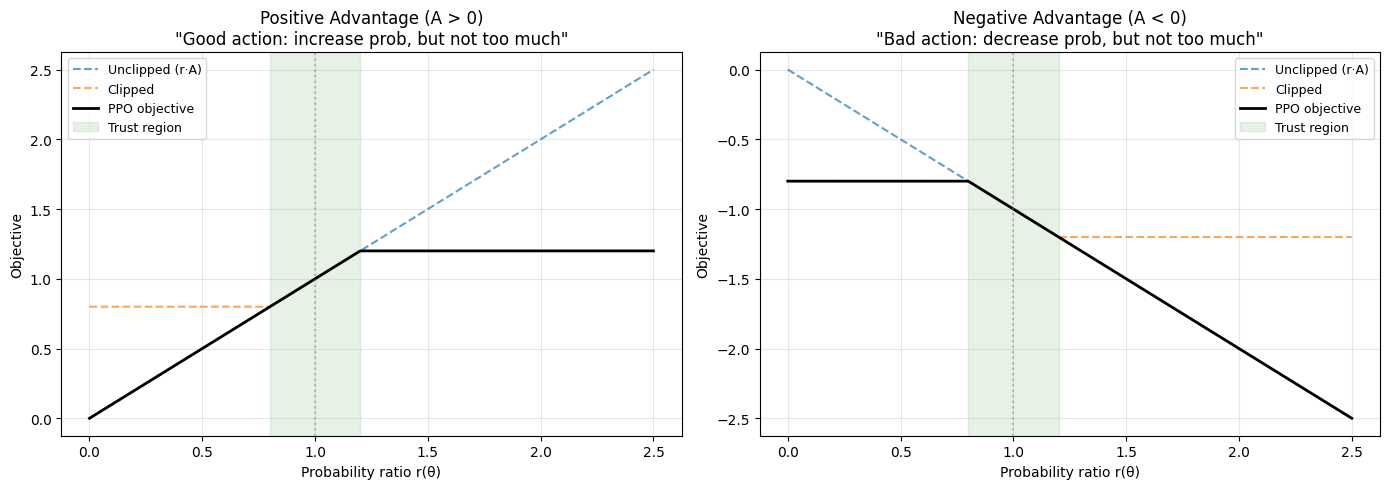

Key insight: The clip creates a 'trust region' around r=1.
The policy can only change by ±ε per update step.
With ε=0.2, ratio stays in [0.8, 1.2]


In [2]:
# Visualize the clipped objective
clip_eps = 0.2
r = np.linspace(0, 2.5, 500)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Case 1: Positive advantage (good action, want to increase probability)
A_pos = 1.0
surr1_pos = r * A_pos
surr2_pos = np.clip(r, 1 - clip_eps, 1 + clip_eps) * A_pos
objective_pos = np.minimum(surr1_pos, surr2_pos)

ax = axes[0]
ax.plot(r, surr1_pos, '--', label='Unclipped (r·A)', alpha=0.7)
ax.plot(r, surr2_pos, '--', label='Clipped', alpha=0.7)
ax.plot(r, objective_pos, 'k-', linewidth=2, label='PPO objective')
ax.axvline(x=1, color='gray', linestyle=':', alpha=0.5)
ax.axvspan(1-clip_eps, 1+clip_eps, alpha=0.1, color='green', label='Trust region')
ax.set_xlabel('Probability ratio r(θ)')
ax.set_ylabel('Objective')
ax.set_title('Positive Advantage (A > 0)\n"Good action: increase prob, but not too much"')
ax.legend(fontsize=9)
ax.grid(True, alpha=0.3)

# Case 2: Negative advantage (bad action, want to decrease probability)
A_neg = -1.0
surr1_neg = r * A_neg
surr2_neg = np.clip(r, 1 - clip_eps, 1 + clip_eps) * A_neg
objective_neg = np.minimum(surr1_neg, surr2_neg)

ax = axes[1]
ax.plot(r, surr1_neg, '--', label='Unclipped (r·A)', alpha=0.7)
ax.plot(r, surr2_neg, '--', label='Clipped', alpha=0.7)
ax.plot(r, objective_neg, 'k-', linewidth=2, label='PPO objective')
ax.axvline(x=1, color='gray', linestyle=':', alpha=0.5)
ax.axvspan(1-clip_eps, 1+clip_eps, alpha=0.1, color='green', label='Trust region')
ax.set_xlabel('Probability ratio r(θ)')
ax.set_ylabel('Objective')
ax.set_title('Negative Advantage (A < 0)\n"Bad action: decrease prob, but not too much"')
ax.legend(fontsize=9)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("Key insight: The clip creates a 'trust region' around r=1.")
print("The policy can only change by ±ε per update step.")
print(f"With ε={clip_eps}, ratio stays in [{1-clip_eps}, {1+clip_eps}]")

---
## 3. Generalized Advantage Estimation (GAE)

How do we estimate the advantage $A(s,a)$?

**One-step TD**: $A_t = r_t + \gamma V(s_{t+1}) - V(s_t)$
- Low variance, high bias

**Monte Carlo**: $A_t = G_t - V(s_t)$  where $G_t = \sum r$
- High variance, low bias

**GAE** interpolates with parameter $\lambda$:

$$A^{GAE}_t = \sum_{l=0}^{T-t} (\gamma\lambda)^l \delta_{t+l}$$

where $\delta_t = r_t + \gamma V(s_{t+1}) - V(s_t)$ is the TD error.

| λ | Behavior |
|---|----------|
| 0 | One-step TD (high bias, low variance) |
| 0.95 | Good default |
| 1 | Monte Carlo (low bias, high variance) |

---
## 4. The Full PPO Algorithm

```
for iteration = 1, 2, ...:
    # 1. Collect rollout
    Run policy π_old for T timesteps, store (s, a, r, done, log_prob, value)

    # 2. Compute advantages
    Compute GAE advantages A_t and returns R_t

    # 3. PPO update (multiple epochs!)
    for epoch = 1 to K:
        for mini-batch in shuffle(rollout):
            r(θ) = π_new(a|s) / π_old(a|s)
            L_clip = min(r·A, clip(r, 1-ε, 1+ε)·A)
            L_value = MSE(V(s), R_t)
            L_entropy = -H(π)
            Loss = -L_clip + c1·L_value - c2·L_entropy
            Update θ with gradient descent
```

**Three losses combined**:
1. **Policy loss** (clipped): Improve the policy
2. **Value loss**: Train the critic
3. **Entropy bonus**: Prevent premature convergence

---
## 5. Train PPO on CartPole

In [3]:
def train_ppo(env_id="CartPole-v1", n_iterations=200, rollout_steps=2048, **kwargs):
    """
    Train PPO and return metrics.
    
    Args:
        env_id: Gymnasium environment ID
        n_iterations: Number of rollout+update cycles
        rollout_steps: Steps to collect before each update
        **kwargs: PPO hyperparameters
    
    Returns:
        Tuple of (agent, metrics dict)
    """
    env = gym.make(env_id)
    obs_dim = env.observation_space.shape[0]
    n_actions = env.action_space.n
    
    agent = PPOAgent(obs_dim=obs_dim, n_actions=n_actions, device=device, **kwargs)
    
    all_rewards = []
    policy_losses = []
    value_losses = []
    entropies = []
    
    state, _ = env.reset()
    ep_reward = 0
    
    for iteration in range(n_iterations):
        # Collect rollout
        for step in range(rollout_steps):
            action, log_prob, value = agent.select_action(state, training=True)
            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            
            agent.store_transition(state, action, reward, done, log_prob, value)
            ep_reward += reward
            state = next_state
            
            if done:
                all_rewards.append(ep_reward)
                ep_reward = 0
                state, _ = env.reset()
        
        # PPO update
        metrics = agent.update()
        policy_losses.append(metrics['policy_loss'])
        value_losses.append(metrics['value_loss'])
        entropies.append(metrics['entropy'])
        
        if (iteration + 1) % 20 == 0:
            recent = all_rewards[-20:] if len(all_rewards) >= 20 else all_rewards
            avg = np.mean(recent) if recent else 0
            print(f"Iter {iteration+1}: avg reward = {avg:.1f}, "
                  f"policy_loss = {metrics['policy_loss']:.4f}, "
                  f"entropy = {metrics['entropy']:.3f}")
    
    env.close()
    return agent, {
        'rewards': all_rewards,
        'policy_losses': policy_losses,
        'value_losses': value_losses,
        'entropies': entropies,
    }

In [4]:
# Train PPO on CartPole
ppo_agent, ppo_metrics = train_ppo(
    env_id="CartPole-v1",
    n_iterations=100,
    rollout_steps=2048,
    hidden_dim=64,
    lr=3e-4,
    gamma=0.99,
    gae_lambda=0.95,
    clip_eps=0.2,
    n_epochs=4,
    batch_size=64,
    seed=42,
)

Iter 20: avg reward = 69.3, policy_loss = 0.0075, entropy = 0.606
Iter 40: avg reward = 109.9, policy_loss = 0.0265, entropy = 0.573
Iter 60: avg reward = 128.6, policy_loss = 0.0010, entropy = 0.558
Iter 80: avg reward = 131.7, policy_loss = 0.0091, entropy = 0.595
Iter 100: avg reward = 198.4, policy_loss = 0.0079, entropy = 0.586


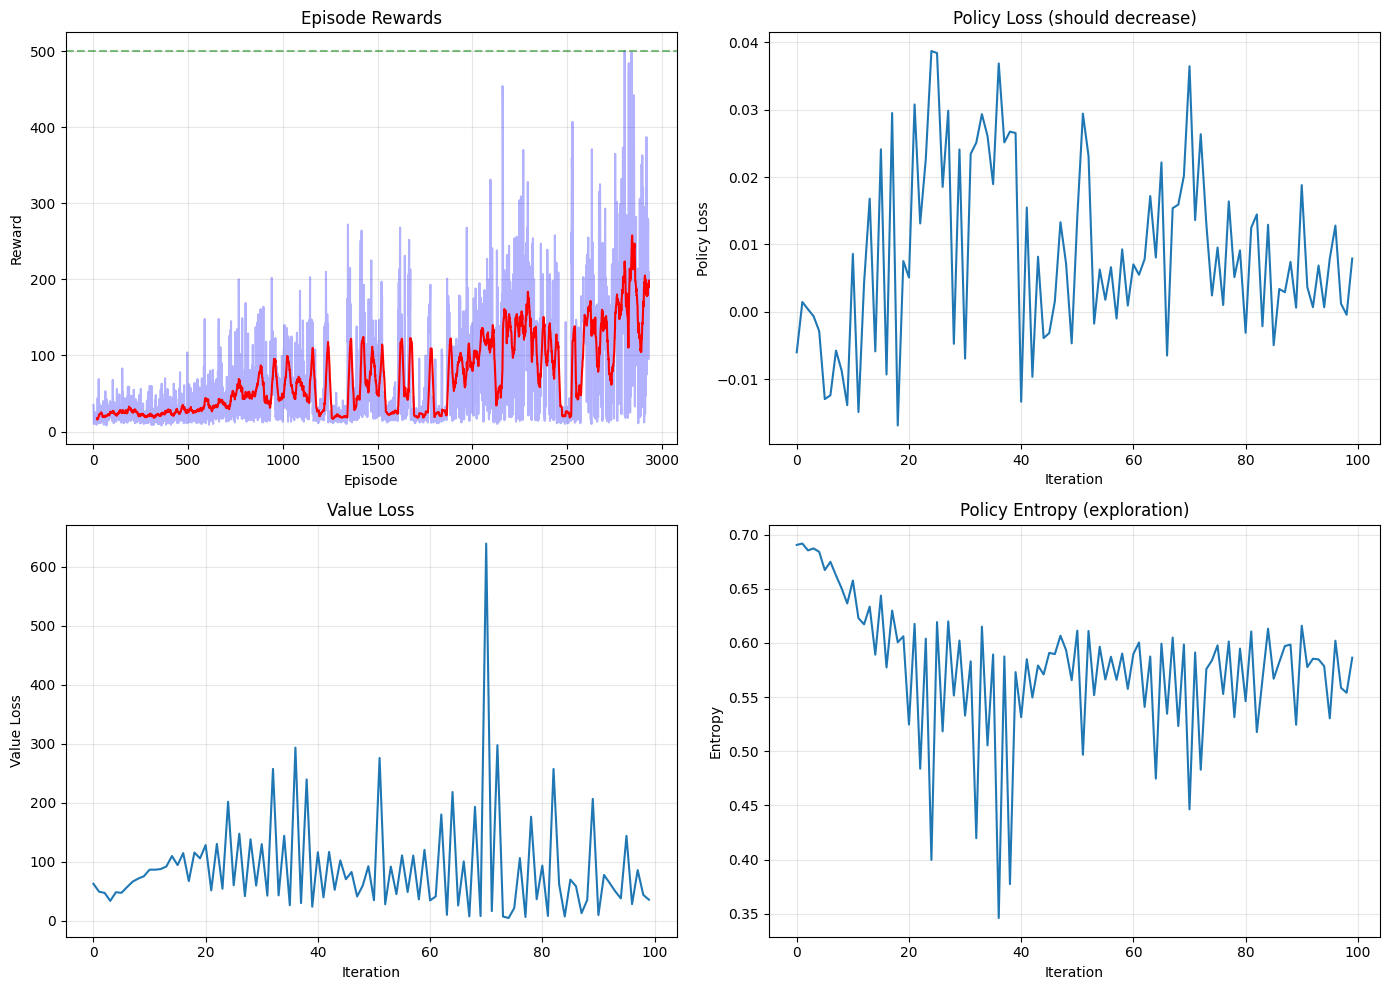

In [5]:
# Plot PPO training metrics
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Rewards
ax = axes[0, 0]
ax.plot(ppo_metrics['rewards'], alpha=0.3, color='blue')
window = 20
if len(ppo_metrics['rewards']) > window:
    rolling = np.convolve(ppo_metrics['rewards'], np.ones(window)/window, mode='valid')
    ax.plot(range(window-1, len(ppo_metrics['rewards'])), rolling, color='red')
ax.axhline(y=500, color='green', linestyle='--', alpha=0.5)
ax.set_xlabel('Episode')
ax.set_ylabel('Reward')
ax.set_title('Episode Rewards')
ax.grid(True, alpha=0.3)

# Policy loss
ax = axes[0, 1]
ax.plot(ppo_metrics['policy_losses'])
ax.set_xlabel('Iteration')
ax.set_ylabel('Policy Loss')
ax.set_title('Policy Loss (should decrease)')
ax.grid(True, alpha=0.3)

# Value loss
ax = axes[1, 0]
ax.plot(ppo_metrics['value_losses'])
ax.set_xlabel('Iteration')
ax.set_ylabel('Value Loss')
ax.set_title('Value Loss')
ax.grid(True, alpha=0.3)

# Entropy
ax = axes[1, 1]
ax.plot(ppo_metrics['entropies'])
ax.set_xlabel('Iteration')
ax.set_ylabel('Entropy')
ax.set_title('Policy Entropy (exploration)')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

---
## 6. PPO on LunarLander

In [6]:
ll_agent, ll_metrics = train_ppo(
    env_id="LunarLander-v3",
    n_iterations=200,
    rollout_steps=2048,
    hidden_dim=128,
    lr=3e-4,
    gamma=0.99,
    gae_lambda=0.95,
    clip_eps=0.2,
    n_epochs=4,
    batch_size=64,
    seed=42,
)

/Users/karthik/Projects/Personal/Reinforcement-Learning/.venv/lib/python3.11/site-packages/pygame/pkgdata.py:25: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import resource_stream, resource_exists


Iter 20: avg reward = -192.9, policy_loss = 0.0017, entropy = 1.354
Iter 40: avg reward = -169.2, policy_loss = 0.0012, entropy = 1.358
Iter 60: avg reward = -141.0, policy_loss = -0.0018, entropy = 1.213
Iter 80: avg reward = -135.8, policy_loss = 0.0004, entropy = 1.102
Iter 100: avg reward = -95.5, policy_loss = -0.0042, entropy = 1.045
Iter 120: avg reward = -29.7, policy_loss = -0.0031, entropy = 1.151
Iter 140: avg reward = 8.6, policy_loss = 0.0015, entropy = 1.011
Iter 160: avg reward = 42.9, policy_loss = -0.0013, entropy = 0.967
Iter 180: avg reward = 64.9, policy_loss = -0.0014, entropy = 0.987
Iter 200: avg reward = 76.9, policy_loss = 0.0022, entropy = 1.051


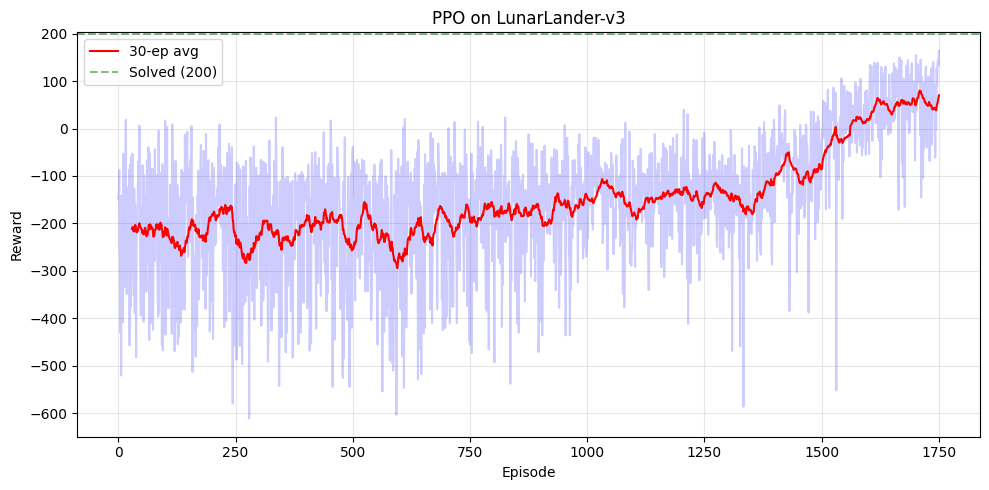

In [7]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(ll_metrics['rewards'], alpha=0.2, color='blue')
window = 30
if len(ll_metrics['rewards']) > window:
    rolling = np.convolve(ll_metrics['rewards'], np.ones(window)/window, mode='valid')
    ax.plot(range(window-1, len(ll_metrics['rewards'])), rolling, color='red', label=f'{window}-ep avg')
ax.axhline(y=200, color='green', linestyle='--', alpha=0.5, label='Solved (200)')
ax.set_xlabel('Episode')
ax.set_ylabel('Reward')
ax.set_title('PPO on LunarLander-v3')
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

---
## 7. Ablation: Clipping Epsilon

In [8]:
# Compare different clipping values
clip_results = {}
for eps in [0.1, 0.2, 0.3, 0.5]:
    print(f"\nTraining with clip_eps={eps}...")
    _, metrics = train_ppo(
        env_id="CartPole-v1",
        n_iterations=60,
        rollout_steps=2048,
        clip_eps=eps,
        seed=42,
    )
    clip_results[f"ε={eps}"] = metrics


Training with clip_eps=0.1...
Iter 20: avg reward = 51.9, policy_loss = -0.0042, entropy = 0.601
Iter 40: avg reward = 110.2, policy_loss = 0.0368, entropy = 0.614
Iter 60: avg reward = 126.7, policy_loss = 0.0190, entropy = 0.591

Training with clip_eps=0.2...
Iter 20: avg reward = 56.7, policy_loss = -0.0047, entropy = 0.611
Iter 40: avg reward = 21.9, policy_loss = 0.0226, entropy = 0.371
Iter 60: avg reward = 128.7, policy_loss = 0.0318, entropy = 0.581

Training with clip_eps=0.3...
Iter 20: avg reward = 37.7, policy_loss = -0.0200, entropy = 0.548
Iter 40: avg reward = 122.8, policy_loss = 0.0046, entropy = 0.575
Iter 60: avg reward = 129.3, policy_loss = -0.0039, entropy = 0.574

Training with clip_eps=0.5...
Iter 20: avg reward = 31.6, policy_loss = -0.0604, entropy = 0.526
Iter 40: avg reward = 118.8, policy_loss = 0.0102, entropy = 0.555
Iter 60: avg reward = 100.8, policy_loss = -0.0261, entropy = 0.535


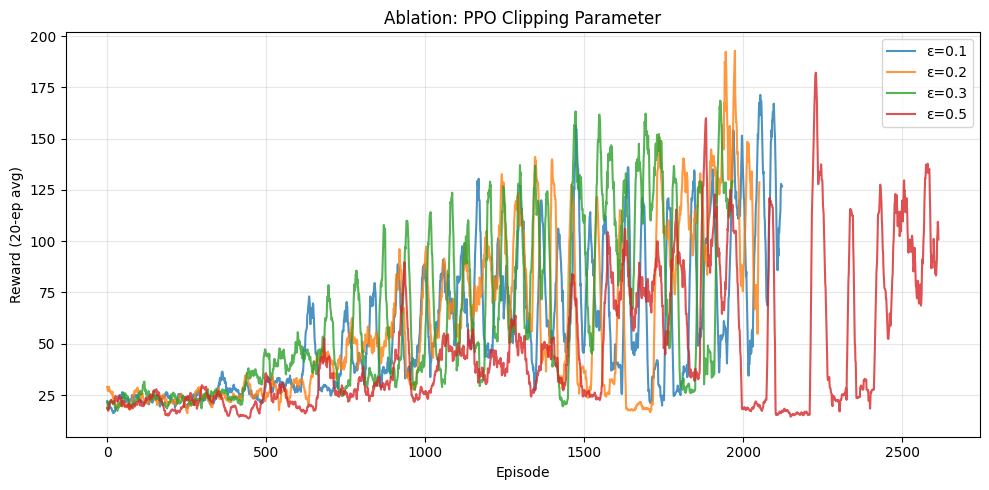

In [9]:
fig, ax = plt.subplots(figsize=(10, 5))
window = 20
for label, data in clip_results.items():
    if len(data['rewards']) > window:
        rolling = np.convolve(data['rewards'], np.ones(window)/window, mode='valid')
        ax.plot(rolling, label=label, alpha=0.8)
ax.set_xlabel('Episode')
ax.set_ylabel(f'Reward ({window}-ep avg)')
ax.set_title('Ablation: PPO Clipping Parameter')
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

---
## 8. PPO → RLHF: The Connection

In standard RL (what we just did):
```
Policy:  π(action | state)         → neural net playing CartPole
Reward:  game score                 → +1 for staying alive
PPO:     update π to maximize reward
```

In RLHF (aligning language models):
```
Policy:  π(next_token | context)    → the language model!
Reward:  reward_model(response)     → trained from human preferences
PPO:     update LM to maximize reward model score
         + KL penalty to stay close to original model
```

### The RLHF Objective

$$\max_\theta \mathbb{E}_{x \sim D, y \sim \pi_\theta(y|x)} \left[ R(x, y) - \beta \cdot D_{KL}(\pi_\theta || \pi_{ref}) \right]$$

- $R(x, y)$: Reward model score for response $y$ to prompt $x$
- $D_{KL}$: KL divergence from reference (pre-trained) model
- $\beta$: Controls how far the model can drift from the original

The KL penalty is like PPO's clipping — **prevent the policy from changing too drastically**.

### What Changes Between RL and RLHF?

| RL (CartPole) | RLHF (Language Model) |
|---------------|----------------------|
| State = observation | State = token context |
| Action = discrete choice | Action = next token (vocab ~50k) |
| Small network (128 hidden) | Billions of parameters |
| Env gives reward | Reward model gives reward |
| Clip ratio | Clip ratio + KL penalty |

**The core PPO algorithm is the same!**

---
## Key Takeaways

1. **PPO clips the policy update** to prevent catastrophic changes

2. **GAE** balances bias-variance in advantage estimation

3. **Multiple mini-batch epochs** per rollout → data efficient

4. **Entropy bonus** keeps exploration alive

5. **PPO = the bridge to RLHF**. Same algorithm, different policy (LM) and reward (reward model)

---
## Next: Phase 3 — RLHF, DPO, and GRPO

Now that we understand PPO, we can explore:
- **RLHF**: PPO + reward model on language models
- **DPO**: Skip the reward model entirely
- **GRPO**: Group-based advantages (DeepSeek's approach)